# Facebook Network Analysis


## Import packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

## Analysis


In [2]:
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz -P ~/Downloads

--2025-04-21 12:02:45--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘/root/Downloads/facebook_combined.txt.gz.1’

facebook_combined.t 100%[===================>] 213.45K   689KB/s    in 0.3s    

2025-04-21 12:02:46 (689 KB/s) - ‘/root/Downloads/facebook_combined.txt.gz.1’ saved [218576/218576]



In [3]:
facebook = pd.read_csv("/root/Downloads/facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
facebook

start_node  end_node
0               0         1
1               0         2
2               0         3
3               0         4
4               0         5
...           ...       ...
88229        4026      4030
88230        4027      4031
88231        4027      4032
88232        4027      4038
88233        4031      4038

[88234 rows x 2 columns]

In [4]:
!chmod 644 ~/Downloads/facebook_combined.txt.gz

In [5]:
G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")

## Visualizing the graph


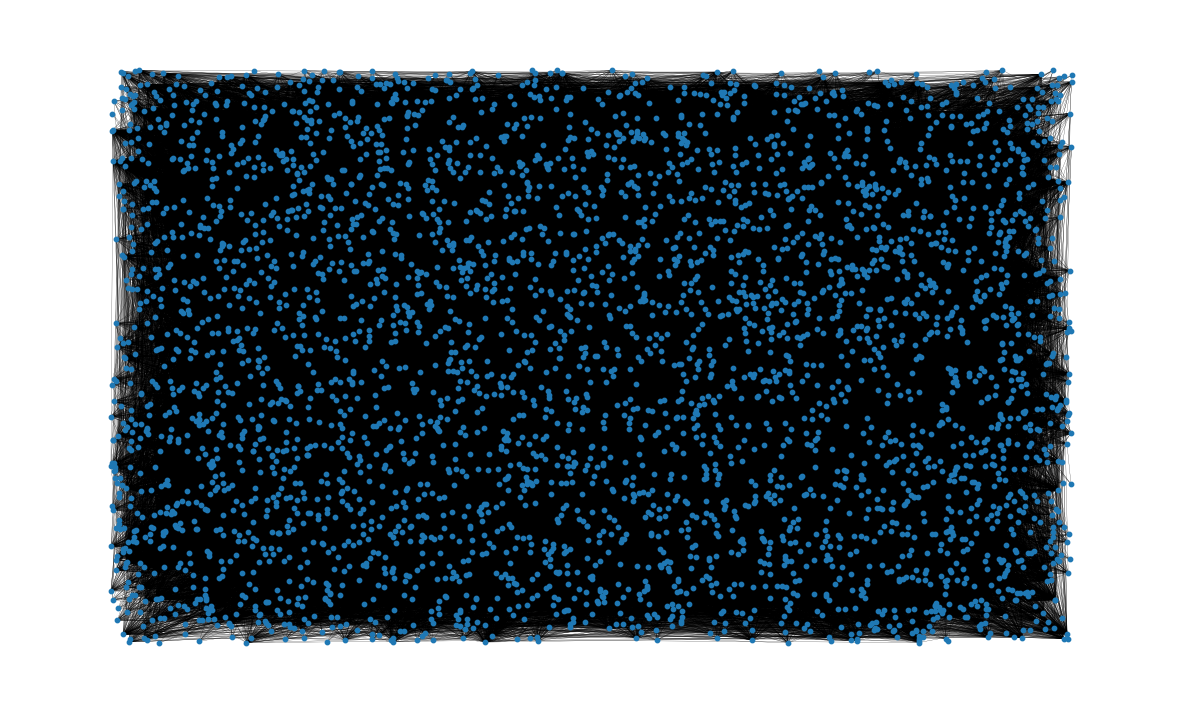

In [6]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

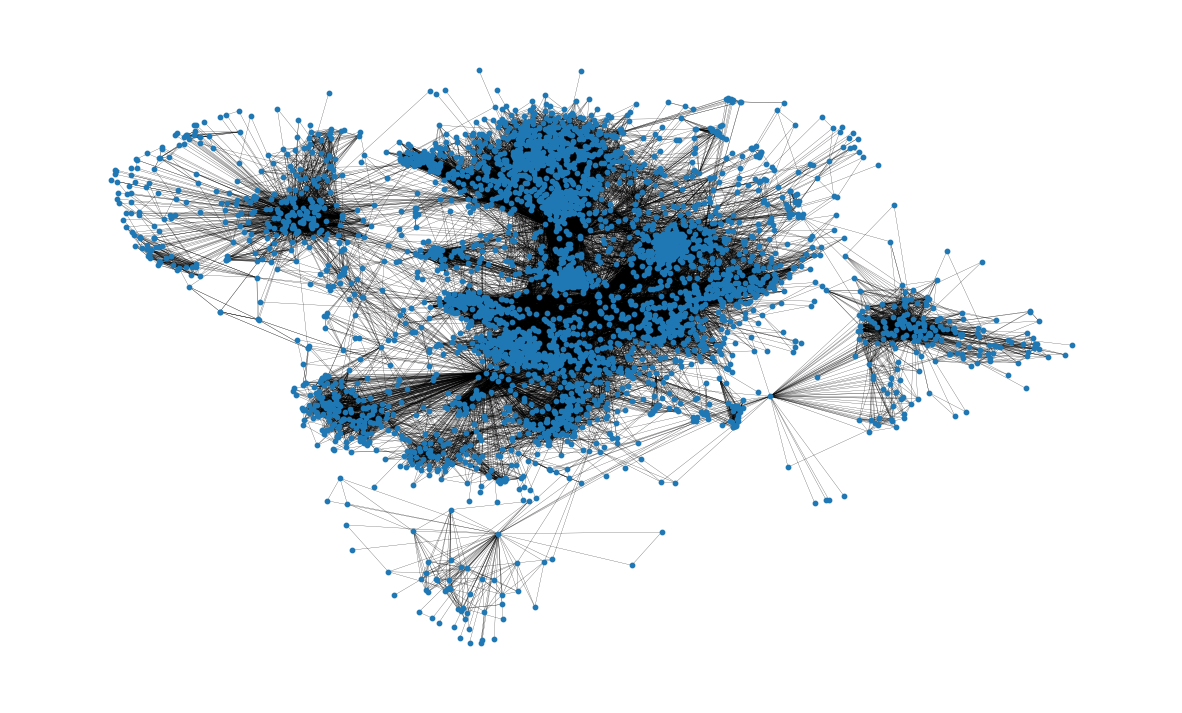

In [7]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)



## Basic topological attributes


In [8]:
G.number_of_nodes()

4039

In [9]:
G.number_of_edges()

88234

In [10]:
np.mean([d for _, d in G.degree()])

43.69101262688784

In [11]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [12]:
shortest_path_lengths[0][42]

1

In [13]:
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())

diameter

8

In [14]:

average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
np.mean(average_path_lengths)

3.691592636562027

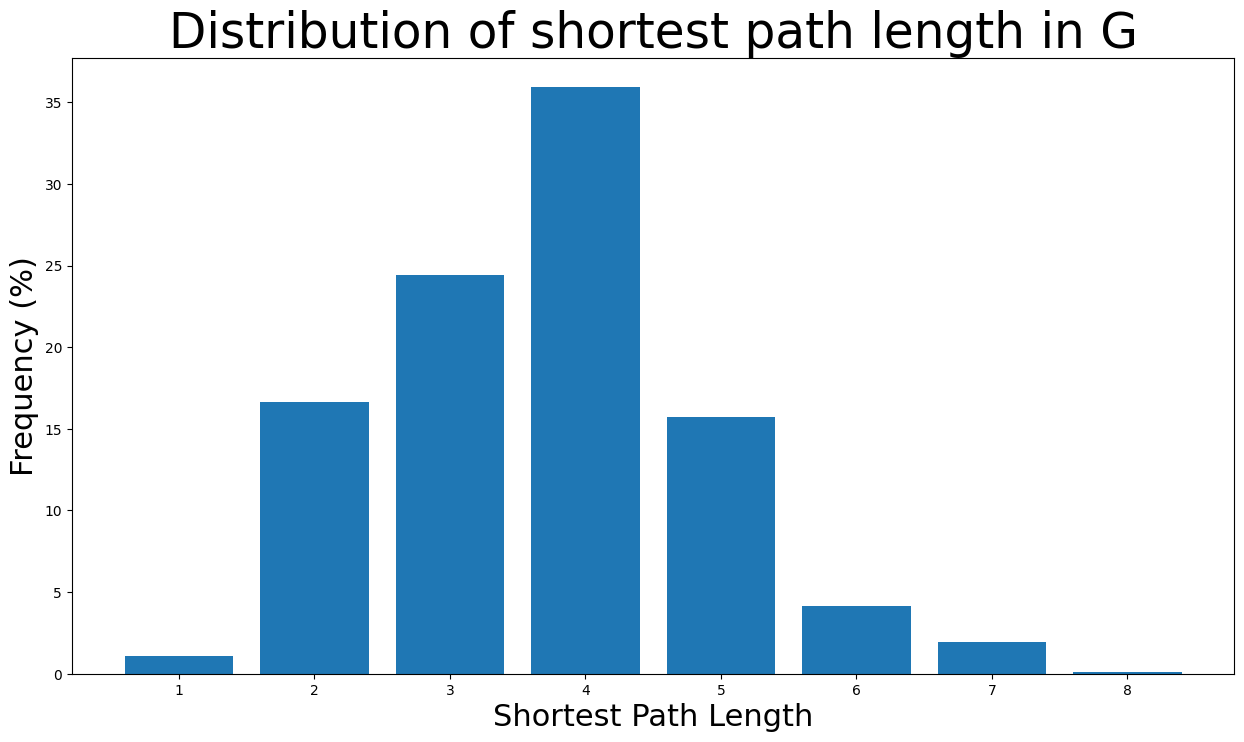

In [15]:

path_lengths = np.zeros(diameter + 1, dtype=int)

for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
ax.set_ylabel("Frequency (%)", fontdict={"size": 22})
plt.savefig("plot1")

In [16]:
nx.density(G)

0.010819963503439287

In [17]:
nx.number_connected_components(G)

1

## Centrality measures


### Degree Centrality


In [18]:
def degree_centrality(G):

    if len(G) <= 1:
        return {n: 1 for n in G}

    s = 1.0 / (len(G) - 1.0)
    centrality = {n: d * s for n, d in G.degree()}
    return centrality


In [19]:
#degree_centrality = nx.centrality.degree_centrality(
degree_centrality = degree_centrality(
    G
)
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.258791480931154),
 (1684, 0.1961367013372957),
 (1912, 0.18697374938088163),
 (3437, 0.13546310054482416),
 (0, 0.08593363051015354),
 (2543, 0.07280832095096582),
 (2347, 0.07206537890044576),
 (1888, 0.0629024269440317)]

In [20]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:8]

[(107, 1045),
 (1684, 792),
 (1912, 755),
 (3437, 547),
 (0, 347),
 (2543, 294),
 (2347, 291),
 (1888, 254)]

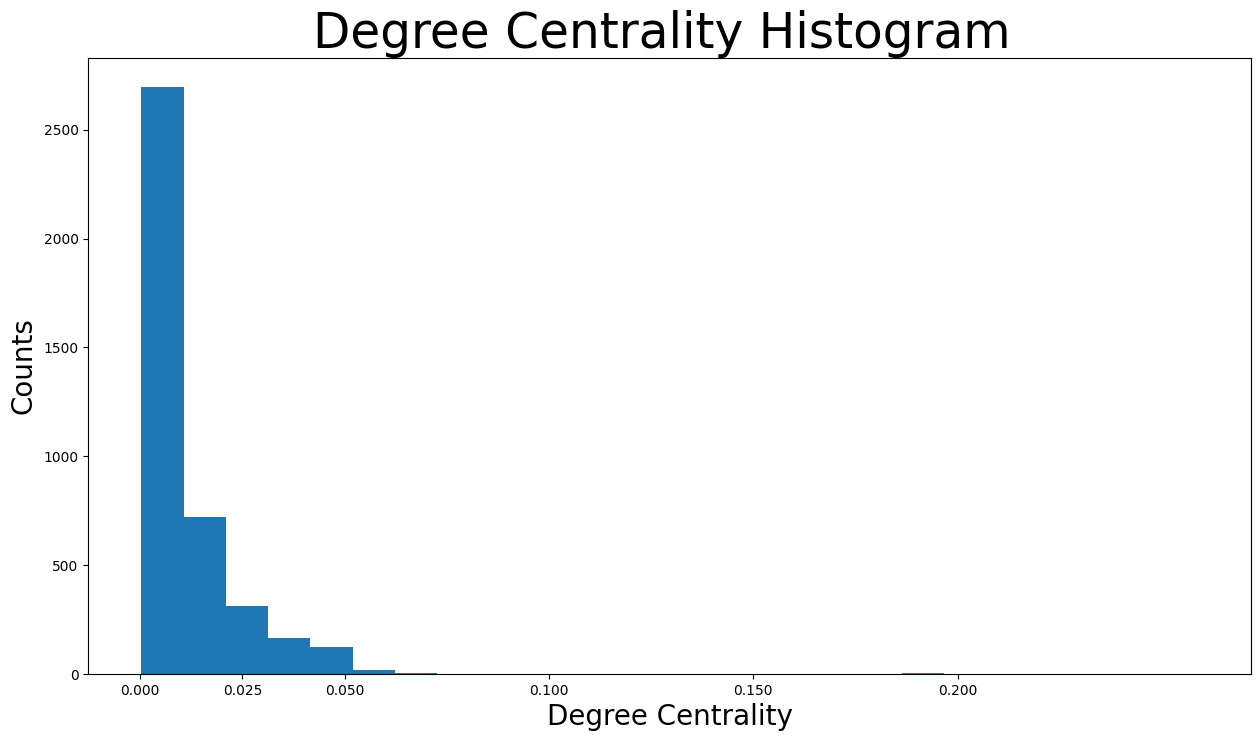

In [21]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})
plt.savefig("plot3")

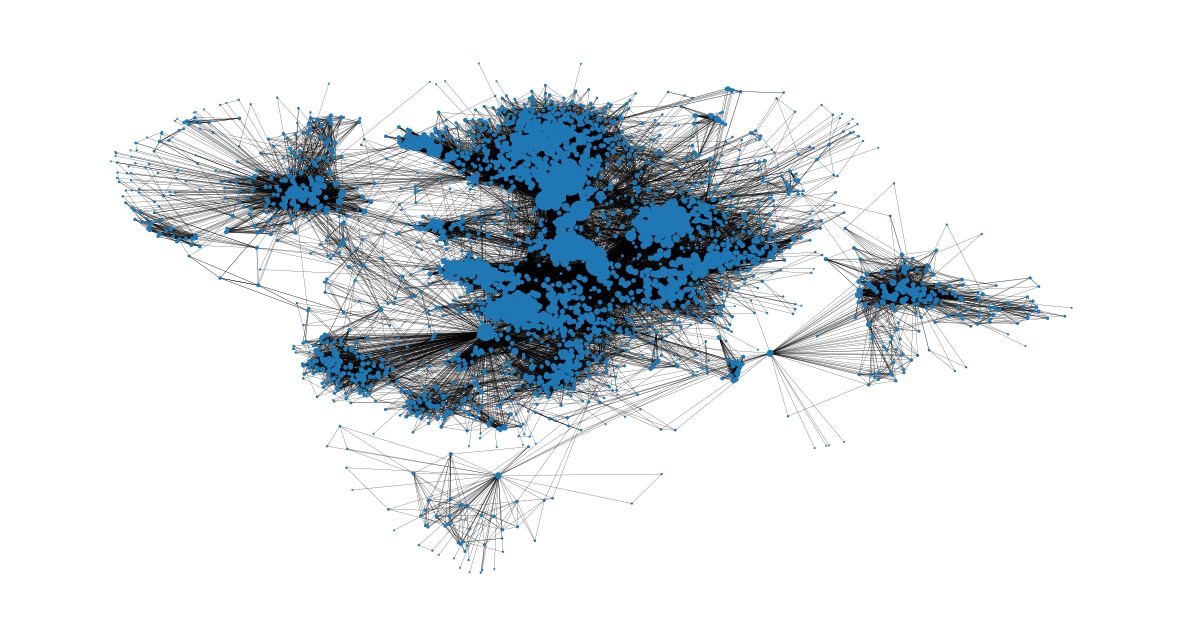

In [22]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")
plt.savefig("image3")

### Betweenness Centrality


In [23]:

def betweenness_centrality(
    G, k=None, normalized=True, weight=None, endpoints=False, seed=None
):
    betweenness = dict.fromkeys(G, 0.0) 
    if k is None:
        nodes = G
    else:
        nodes = seed.sample(dict(G.nodes()), k)
    for s in nodes:
        if weight is None: 
            S, P, sigma, _ = _single_source_shortest_path_basic(G, s)
        else:
            S, P, sigma, _ = _single_source_dijkstra_path_basic(G, s, weight)
        if endpoints:
            betweenness, _ = _accumulate_endpoints(betweenness, S, P, sigma, s)
        else:
            betweenness, _ = _accumulate_basic(betweenness, S, P, sigma, s)
    betweenness = _rescale(
        betweenness,
        len(G),
        normalized=normalized,
        directed=G.is_directed(),
        k=k,
        endpoints=endpoints,
    )
    return betweenness


In [24]:
betweenness_centrality = nx.centrality.betweenness_centrality(
    G
) 
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.4805180785560152),
 (1684, 0.3377974497301992),
 (3437, 0.23611535735892905),
 (1912, 0.2292953395868782),
 (1085, 0.14901509211665306),
 (0, 0.14630592147442917),
 (698, 0.11533045020560802),
 (567, 0.09631033121856215)]

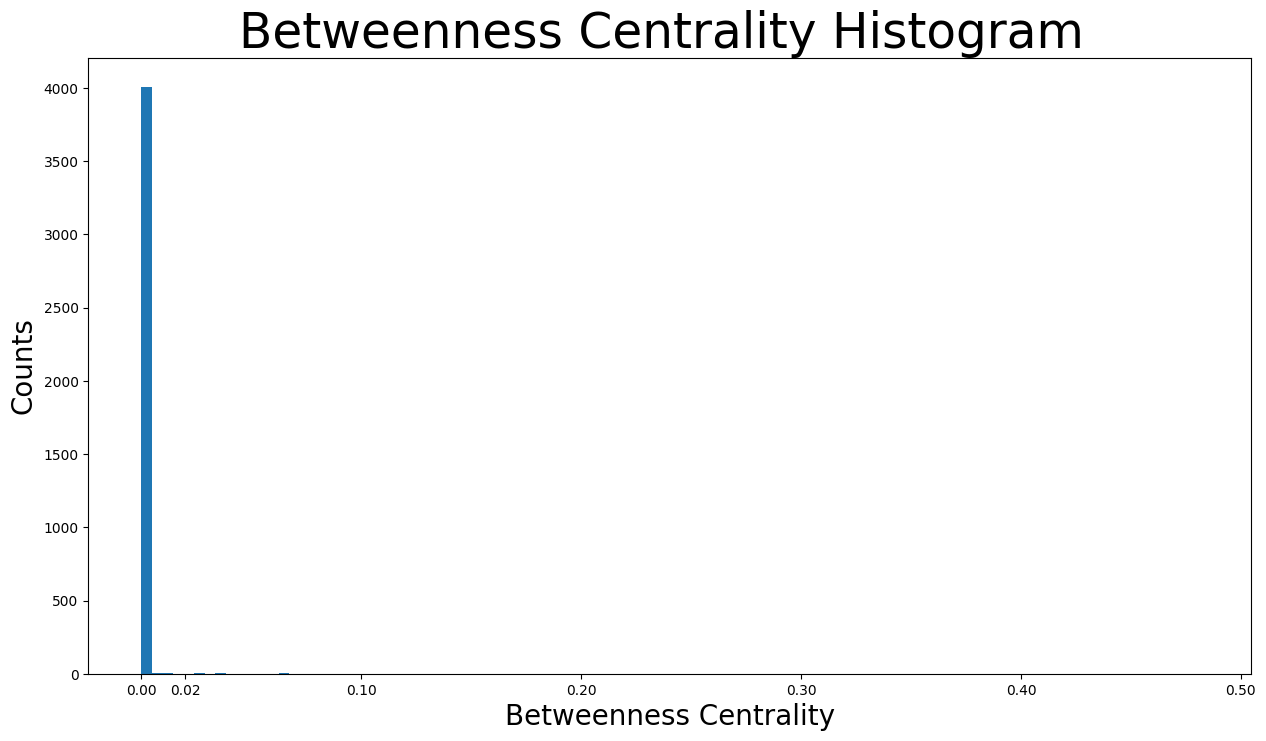

In [25]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})
plt.savefig("plot4")

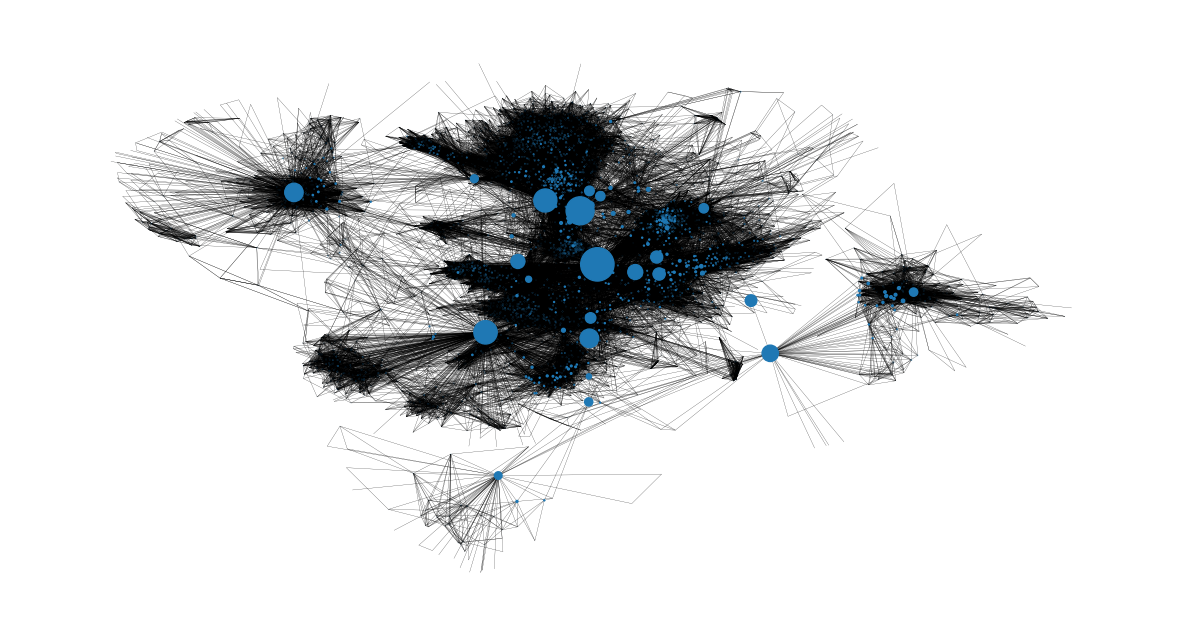

In [26]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")
plt.savefig("image4")

### Closeness Centrality


In [27]:
def closeness_centrality(G, u=None, distance=None, wf_improved=True):
    if G.is_directed():
        G = G.reverse() 

    if distance is not None:
        path_length = functools.partial(
            nx.single_source_dijkstra_path_length, weight=distance
        )
    else:
        path_length = nx.single_source_shortest_path_length

    if u is None:
        nodes = G.nodes
    else:
        nodes = [u]
    closeness_dict = {}
    for n in nodes:
        sp = path_length(G, n)
        totsp = sum(sp.values())
        len_G = len(G)
        _closeness_centrality = 0.0
        if totsp > 0.0 and len_G > 1:
            _closeness_centrality = (len(sp) - 1.0) / totsp
            if wf_improved:
                s = (len(sp) - 1.0) / (len_G - 1)
                _closeness_centrality *= s
        closeness_dict[n] = _closeness_centrality
    if u is not None:
        return closeness_dict[u]
    return closeness_dict

In [28]:
closeness_centrality = nx.centrality.closeness_centrality(
    G
) 
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.45969945355191255),
 (58, 0.3974018305284913),
 (428, 0.3948371956585509),
 (563, 0.3939127889961955),
 (1684, 0.39360561458231796),
 (171, 0.37049270575282134),
 (348, 0.36991572004397216),
 (483, 0.3698479575013739)]

In [29]:
1 / closeness_centrality[107]

2.1753343239227343

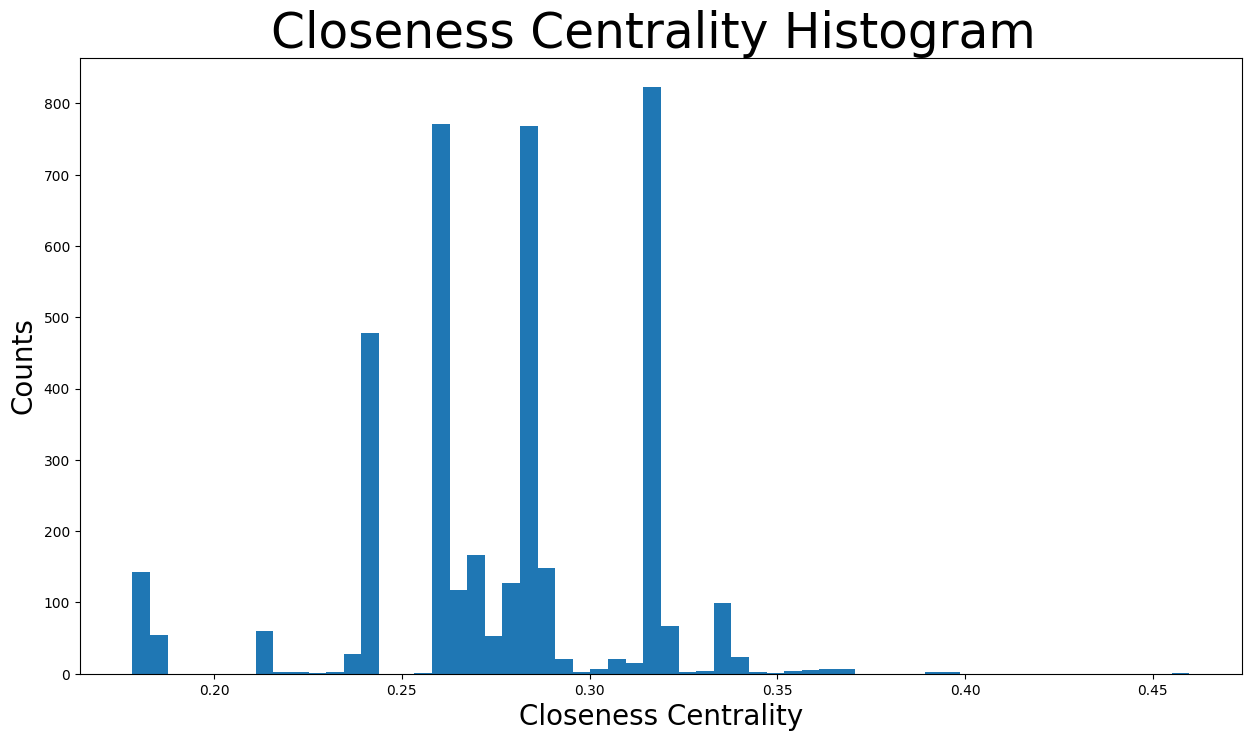

In [30]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})
plt.savefig("plot5")

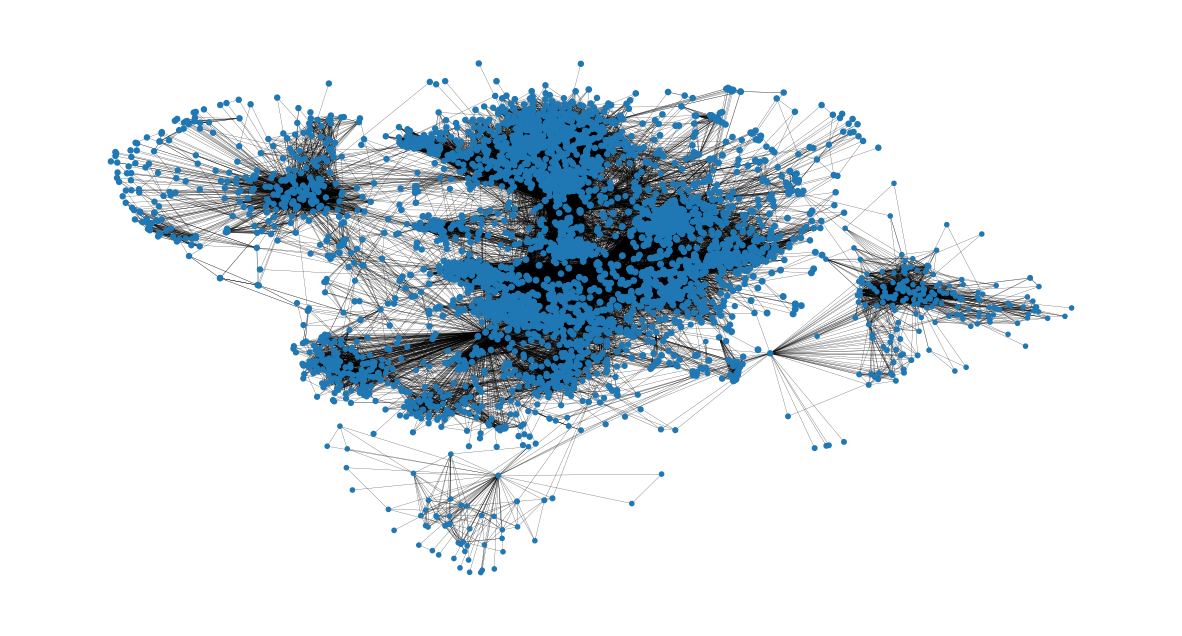

In [31]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")
plt.savefig("image5")

### Eigenvector Centrality


In [32]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(
    G
) 
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(1912, 0.09540696149067629),
 (2266, 0.08698327767886552),
 (2206, 0.08605239270584342),
 (2233, 0.08517340912756598),
 (2464, 0.08427877475676092),
 (2142, 0.08419311897991795),
 (2218, 0.0841557356805503),
 (2078, 0.08413617041724977),
 (2123, 0.08367141238206224),
 (1993, 0.0835324284081597)]

In [33]:
high_eigenvector_centralities = (
    sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
)[
    1:10
] 
high_eigenvector_nodes = [
    tuple[0] for tuple in high_eigenvector_centralities
] 
neighbors_1912 = [n for n in G.neighbors(1912)]
all(
    item in neighbors_1912 for item in high_eigenvector_nodes
)  

True

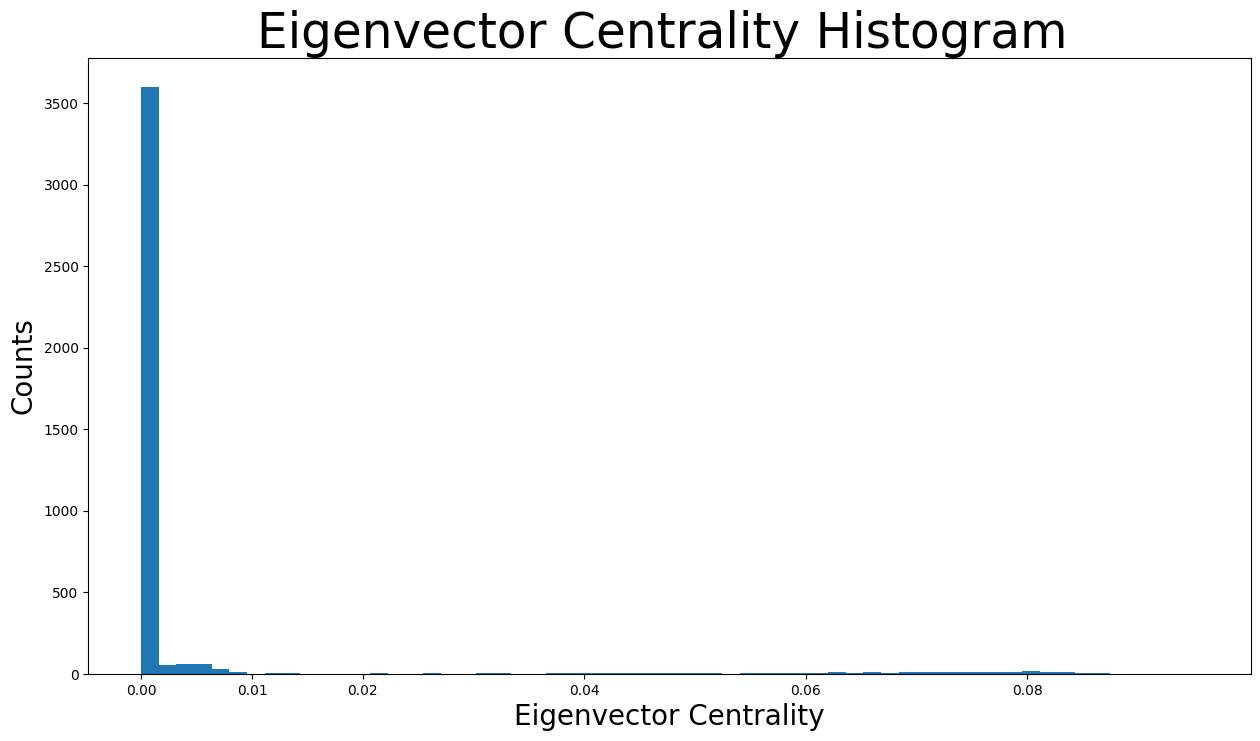

In [34]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.08]) 
plt.title("Eigenvector Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})
plt.savefig("plot6")

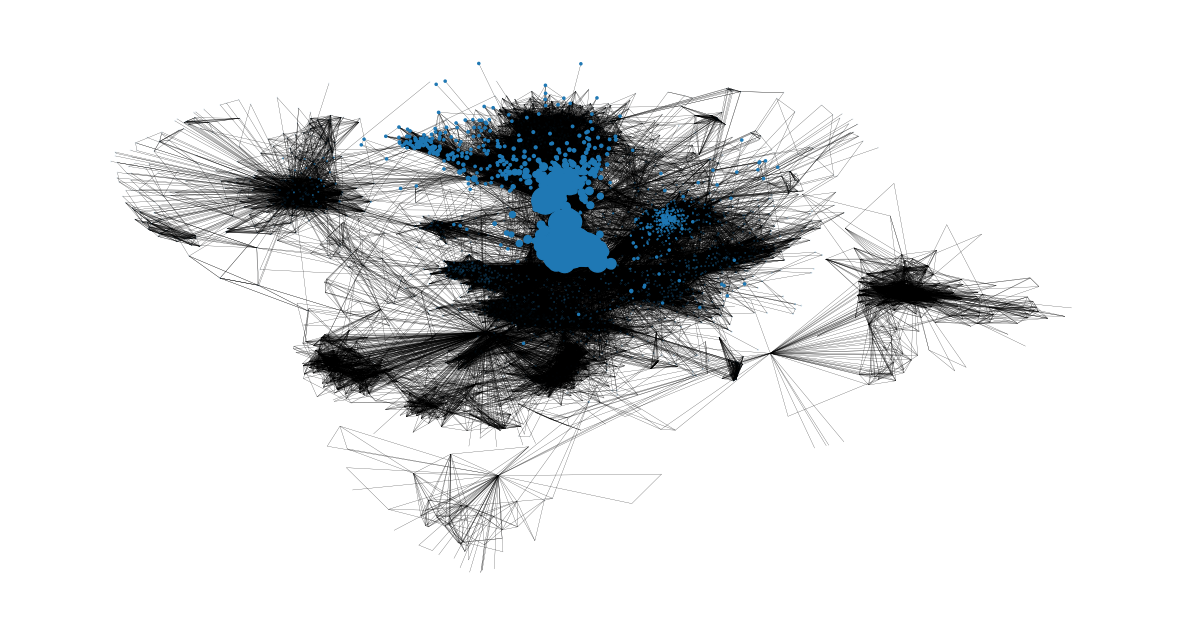

In [35]:
node_size = [
    v * 4000 for v in eigenvector_centrality.values()
] 
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")
plt.savefig("image6")

## Clustering Effects


In [36]:
nx.average_clustering(G)

0.6055467186200876

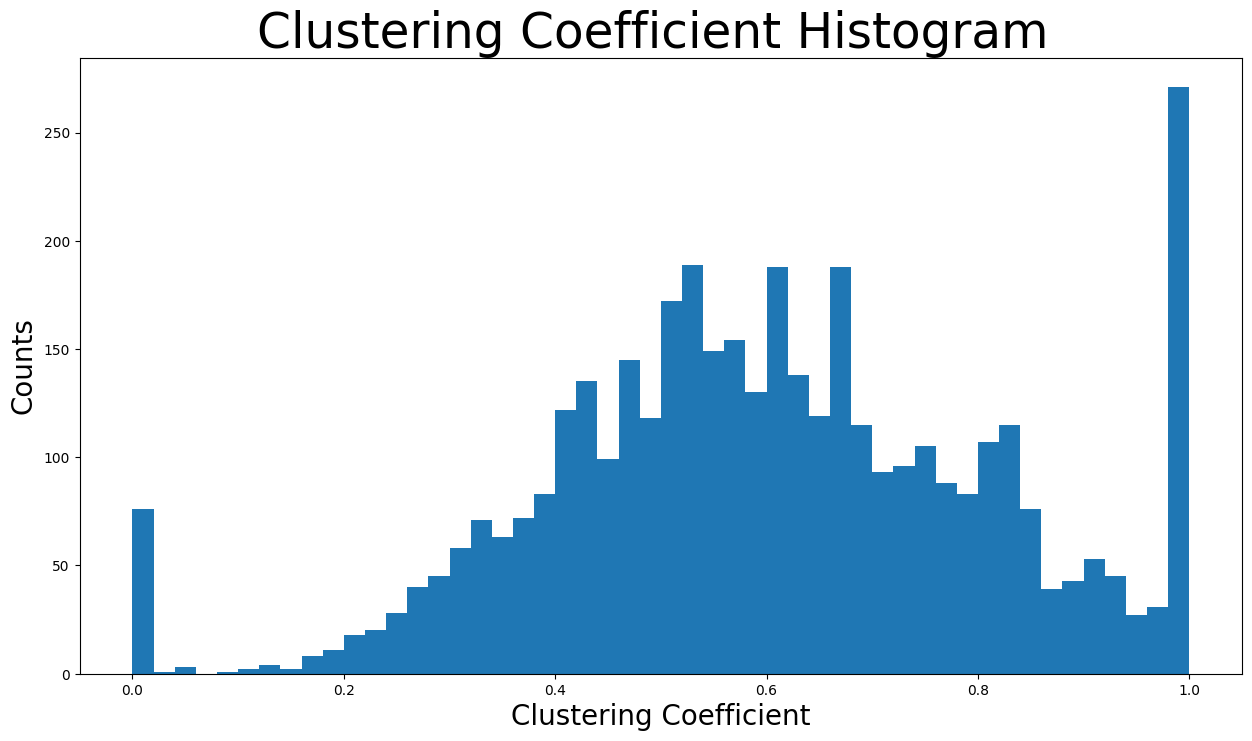

In [37]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})
plt.savefig("plot7")

In [38]:
triangles_per_node = list(nx.triangles(G).values())
sum(
    triangles_per_node
) / 3  

1612010.0

In [39]:
np.mean(triangles_per_node)

1197.3334983906907

In [40]:
np.median(triangles_per_node)

161.0

## Bridges


In [41]:
nx.has_bridges(G)

True

In [42]:
bridges = list(nx.bridges(G))
len(bridges)

75

In [43]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

78

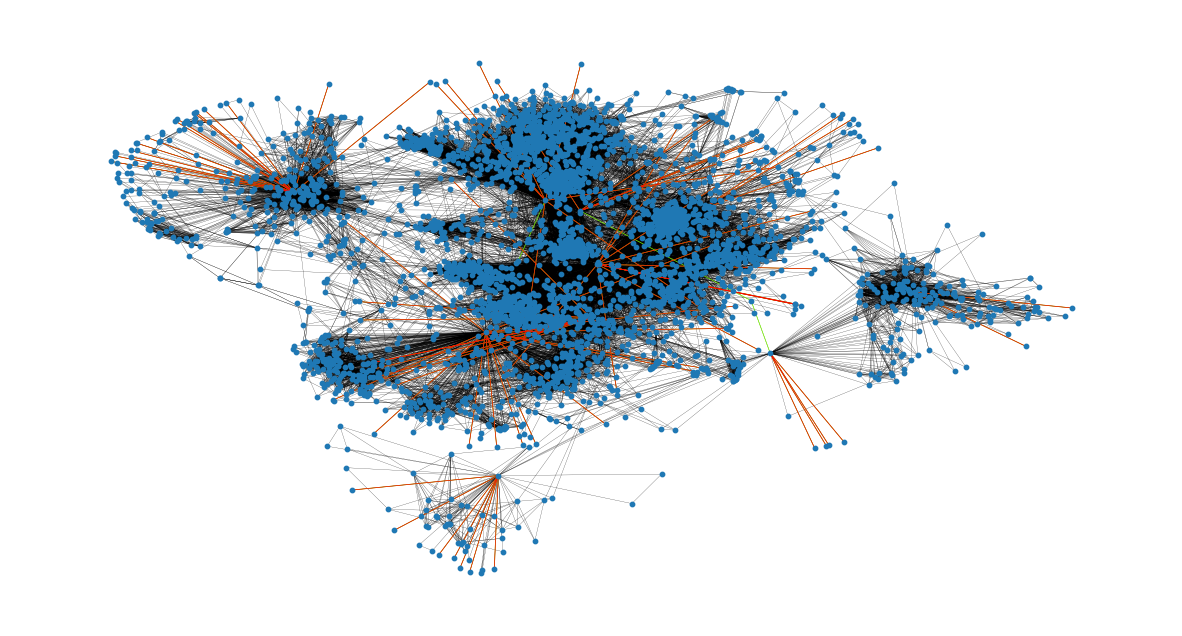

In [44]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
) 
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
) 
plt.axis("off")
plt.savefig("image7")

## Assortativity


In [45]:
nx.degree_assortativity_coefficient(G)

0.06357722918564943

In [46]:
nx.degree_pearson_correlation_coefficient(
    G
) 

0.06357722918564916

## Network Communities


In [47]:
colors = ["" for x in range(G.number_of_nodes())] 
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  
    counter += 1
    for node in list(
        com
    ):  
        colors[node] = color
counter

44

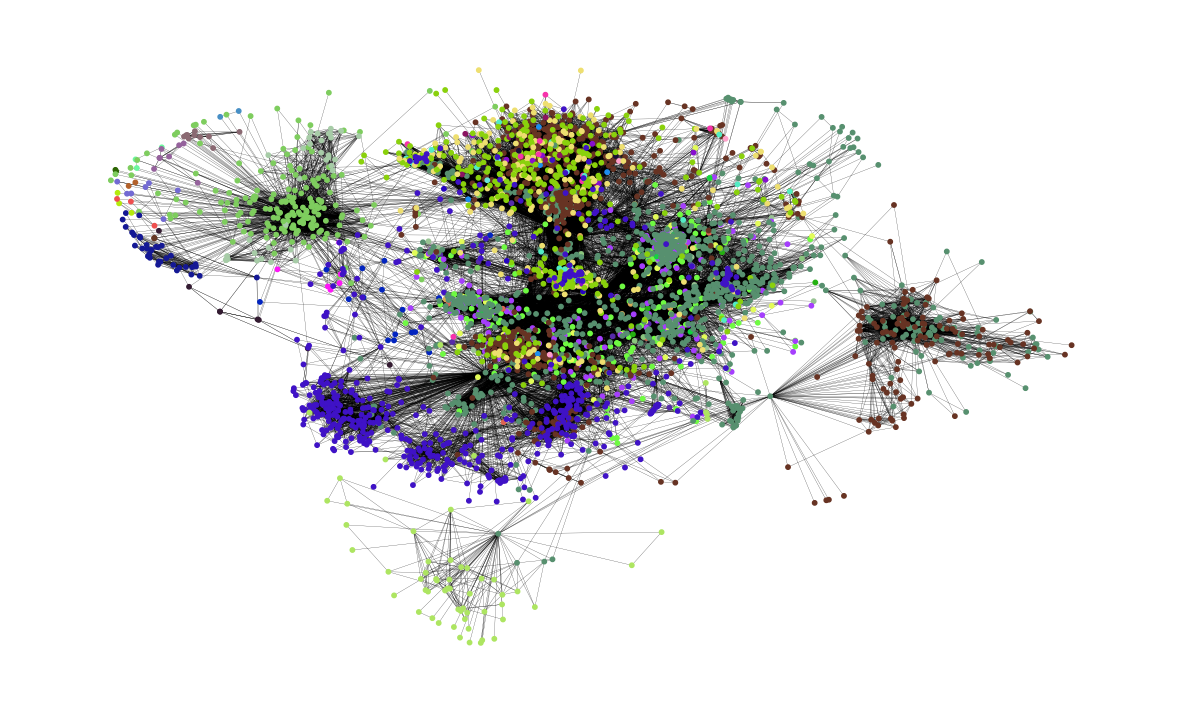

In [48]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)
plt.savefig("image8")

In [49]:
colors = ["" for x in range(G.number_of_nodes())]
for com in nx.community.asyn_fluidc(G, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF) 
    for node in list(com):
        colors[node] = color

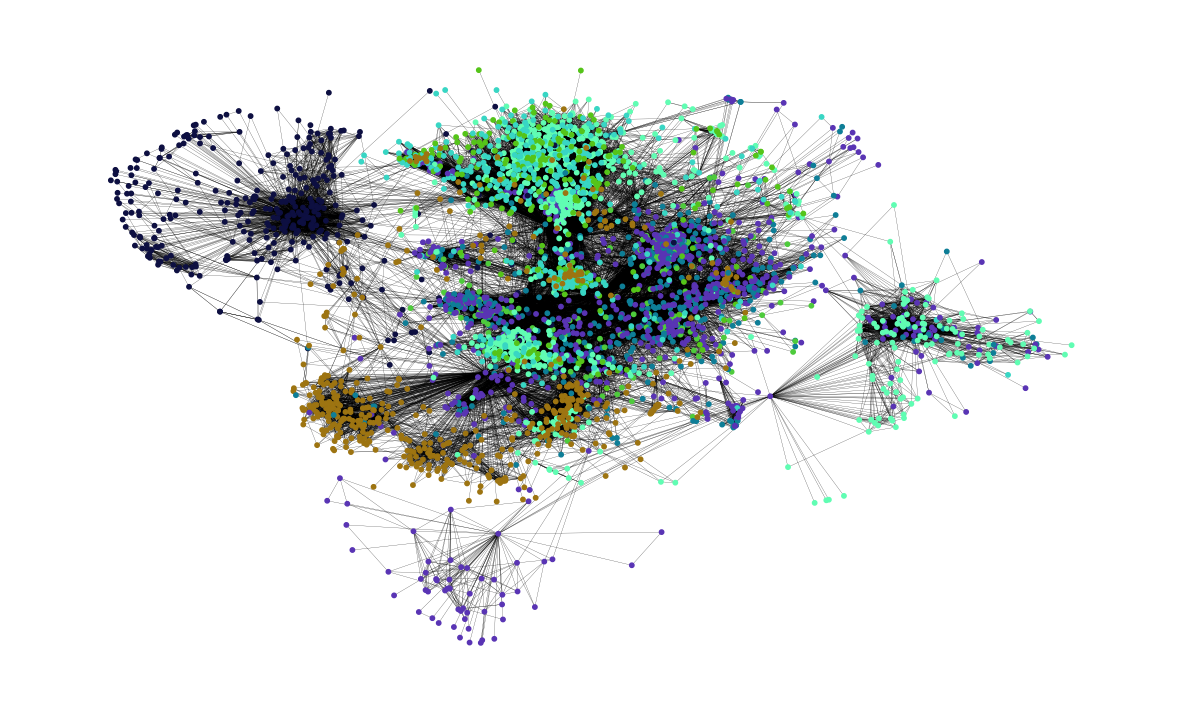

In [50]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)
plt.savefig("image9")

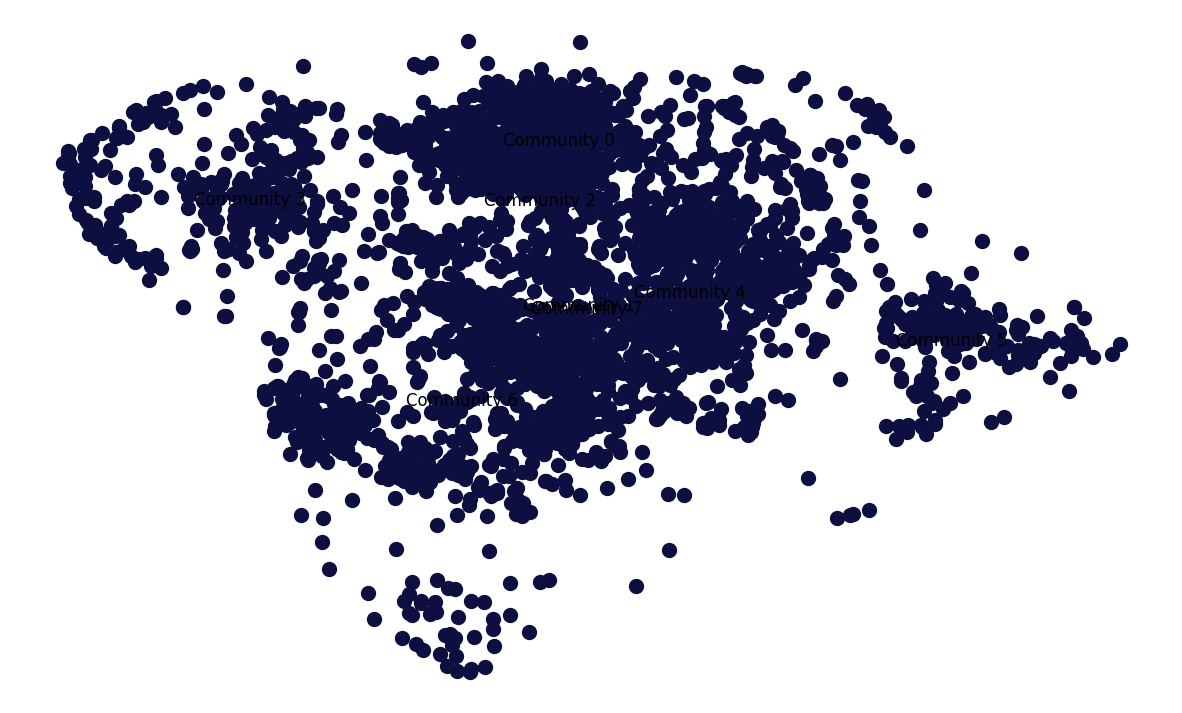

In [51]:
import networkx as nx
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 9))
plt.axis("off")

node_community_map = {}
for i, com in enumerate(nx.community.asyn_fluidc(G, 8, seed=0)):
    for node in com:
        node_community_map[node] = i

community_positions = {}

for node, position in pos.items():
    community_id = node_community_map[node]
    if community_id not in community_positions:
        community_positions[community_id] = [position]
    else:
        community_positions[community_id].append(position)

for community_id, positions in community_positions.items():
    x_coords = [pos[0] for pos in positions]
    y_coords = [pos[1] for pos in positions]
    centroid_x = sum(x_coords) / len(x_coords)
    centroid_y = sum(y_coords) / len(y_coords)
    plt.scatter(x_coords, y_coords, color=colors[community_id], s=100)
    plt.text(centroid_x, centroid_y, f"Community {community_id}", fontsize=12, ha='center', va='center')
plt.savefig("image10")
plt.show()

## Performance Metrices

In [52]:
import networkx as nx
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from time import time

true_labels = {node: 1 if node % 2 == 0 else 0 for node in G.nodes()} 
pred_labels = {node: 1 if node % 3 == 0 else 0 for node in G.nodes()} 

y_true = [true_labels[node] for node in G.nodes()]
y_pred = [pred_labels[node] for node in G.nodes()]

start_time = time()

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision}")

recall = recall_score(y_true, y_pred)
print(f"Recall: {recall}")

f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1}")

end_time = time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Accuracy: 0.5001237930180737
Precision: 0.5003711952487008
Recall: 0.3336633663366337
F1 Score: 0.4003564003564004
Execution time: 0.020797014236450195 seconds


## Random Forest Classifier

In [53]:
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from time import time
import numpy as np

true_labels = {node: 1 if node % 2 == 0 else 0 for node in G.nodes()} 
pred_labels = {node: 1 if node % 3 == 0 else 0 for node in G.nodes()} 

node_degrees = dict(G.degree())
node_cluster_coeffs = nx.clustering(G)

X_train = np.array([[node_degrees[node], node_cluster_coeffs[node]] for node in G.nodes()])
y_train = np.array([true_labels[node] for node in G.nodes()])

rf_model = RandomForestClassifier(n_estimators=100)

start_time = time()

rf_model.fit(X_train, y_train)

predicted_labels = rf_model.predict(X_train)

end_time = time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

accuracy = accuracy_score(y_train, predicted_labels)
precision = precision_score(y_train, predicted_labels)
recall = recall_score(y_train, predicted_labels)
f1 = f1_score(y_train, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Execution time: 0.6072783470153809 seconds
Accuracy: 0.860609061648923
Precision: 0.8658965344048217
Recall: 0.8534653465346534
F1 Score: 0.8596360009972575


## Simulated Annealing

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


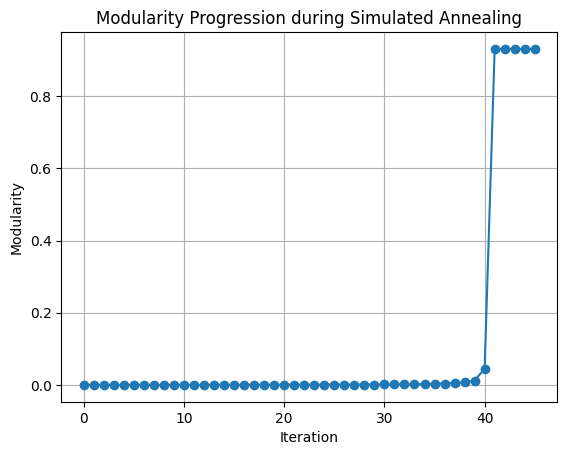

Best Modularity: 0.930709886696187
Accuracy: 0.5588235294117647
Precision: 0.27941176470588236
Recall: 0.5
F1 Score: 0.3584905660377359
Execution Time: 217.9872715473175 seconds


In [54]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def modularity(G, communities):
    m = G.size(weight='weight')
    degrees = dict(G.degree(weight='weight'))
    Q = 0.0
    for community in communities:
        for u in community:
            for v in community:
                if G.has_edge(u, v):
                    Q += G[u][v].get('weight', 1.0) - degrees[u] * degrees[v] / (2 * m)
    return Q / (2 * m)

def simulated_annealing(G, initial_temp, final_temp, alpha, max_iterations):
    nodes = list(G.nodes())
    current_solution = [{node} for node in nodes]
    current_modularity = modularity(G, current_solution)
    best_solution = current_solution
    best_modularity = current_modularity
    temperature = initial_temp

    modularity_values = [current_modularity] 

    while temperature > final_temp:
        for _ in range(max_iterations):
            if len(current_solution) < 2:
                break

            new_solution = current_solution[:]
            community1, community2 = random.sample(new_solution, 2)
            new_solution.remove(community1)
            new_solution.remove(community2)
            new_community = community1.union(community2)
            new_solution.append(new_community)

            new_modularity = modularity(G, new_solution)
            delta_modularity = new_modularity - current_modularity

            if delta_modularity > 0 or random.uniform(0, 1) < math.exp(delta_modularity / temperature):
                current_solution = new_solution
                current_modularity = new_modularity
                if new_modularity > best_modularity:
                    best_solution = new_solution
                    best_modularity = new_modularity

        temperature *= alpha
        modularity_values.append(current_modularity)

    return best_solution, best_modularity, modularity_values

def evaluate_solution(ground_truth, detected):
    ground_truth_labels = []
    detected_labels = []

    node_to_community_ground_truth = {}
    for idx, community in enumerate(ground_truth):
        for node in community:
            node_to_community_ground_truth[node] = idx

    node_to_community_detected = {}
    for idx, community in enumerate(detected):
        for node in community:
            node_to_community_detected[node] = idx

    for node in node_to_community_ground_truth:
        ground_truth_labels.append(node_to_community_ground_truth[node])
        detected_labels.append(node_to_community_detected.get(node, -1))  

    accuracy = accuracy_score(ground_truth_labels, detected_labels)
    precision = precision_score(ground_truth_labels, detected_labels, average='macro')
    recall = recall_score(ground_truth_labels, detected_labels, average='macro')
    f1 = f1_score(ground_truth_labels, detected_labels, average='macro')

    return accuracy, precision, recall, f1

if __name__ == "__main__":
    initial_temp = 10.0
    final_temp = 1.0
    alpha = 0.95
    max_iterations = 100

    ground_truth_communities = [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}, {19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

    start_time = time.time()
    best_solution, best_modularity, modularity_values = simulated_annealing(G, initial_temp, final_temp, alpha, max_iterations)
    end_time = time.time()

    accuracy, precision, recall, f1 = evaluate_solution(ground_truth_communities, best_solution)

    plt.plot(range(len(modularity_values)), modularity_values, marker='o', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Modularity')
    plt.title('Modularity Progression during Simulated Annealing')
    plt.grid(True)
    plt.savefig("plot9")
    plt.show()

    print(f'Best Modularity: {best_modularity}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Execution Time: {end_time - start_time} seconds')


## Particle Swarm Optimization

Best Active Nodes: [0, 834, 4038, 1126, 2088, 1749, 1846, 759, 3200, 107]
Influence of Best Nodes: 1659


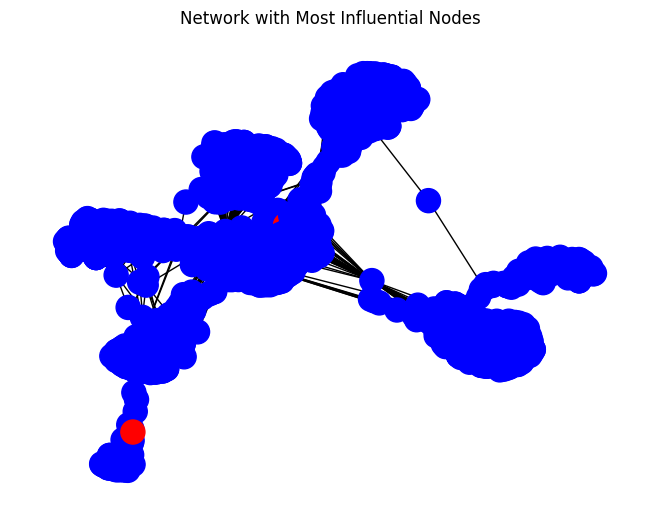

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def calculate_influence(graph, active_nodes):
    influenced_nodes = set(active_nodes)
    for node in active_nodes:
        influenced_nodes.update(graph.neighbors(node))
    return len(influenced_nodes)

def pso_influence_maximization(graph, num_active_nodes, num_particles=20, max_iter=100, w=0.5, c1=1, c2=1):
    num_nodes = graph.number_of_nodes()
    particles = [random.sample(range(num_nodes), num_active_nodes) for _ in range(num_particles)]
    velocities = [[random.uniform(-1, 1) for _ in range(num_active_nodes)] for _ in range(num_particles)]
    best_positions = particles.copy()
    best_fitnesses = [calculate_influence(graph, p) for p in particles]
    global_best_position = particles[best_fitnesses.index(max(best_fitnesses))]
    global_best_fitness = max(best_fitnesses)

    for _ in range(max_iter):
        for i in range(num_particles):
            for j in range(num_active_nodes):
                r1, r2 = random.random(), random.random()
                velocities[i][j] = (w * velocities[i][j] +
                                    c1 * r1 * (best_positions[i][j] - particles[i][j]) +
                                    c2 * r2 * (global_best_position[j] - particles[i][j]))
                particles[i][j] = int(particles[i][j] + velocities[i][j])
                particles[i][j] = max(0, min(particles[i][j], num_nodes - 1))
            particles[i] = list(set(particles[i]))
            particles[i].extend(random.sample(range(num_nodes), num_active_nodes - len(particles[i])))
            fitness = calculate_influence(graph, particles[i])
            if fitness > best_fitnesses[i]:
                best_fitnesses[i] = fitness
                best_positions[i] = particles[i].copy()
                if fitness > global_best_fitness:
                    global_best_fitness = fitness
                    global_best_position = particles[i].copy()

    return global_best_position, global_best_fitness

if __name__ == "__main__":
    num_active_nodes = 10

    best_nodes, best_influence = pso_influence_maximization(G, num_active_nodes)

    print("Best Active Nodes:", best_nodes)
    print("Influence of Best Nodes:", best_influence)

    node_colors = ['red' if node in best_nodes else 'blue' for node in G.nodes]
    nx.draw(G, with_labels=False, node_color=node_colors)
    plt.title("Network with Most Influential Nodes")
    plt.savefig("image11")
    plt.show()

In [56]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=3cde98f163892316f99db914583e43c91271c702675f82797dce12e85e42c325
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [57]:
import networkx as nx
import numpy as np
from pyswarm import pso
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

def modularity_optimized(G, communities):
    m = G.size(weight='weight')
    degrees = dict(G.degree(weight='weight'))
    norm = 1 / (2 * m)

    def community_modularity(community):
        valid_nodes = [node for node in community if node in degrees]
        links_in_community = G.subgraph(valid_nodes).size(weight='weight')
        degree_sum = sum(degrees[node] for node in valid_nodes)
        return links_in_community * norm - (degree_sum * norm) ** 2

    return sum(community_modularity(community) for community in communities)

def decode_particle_optimized(particle, num_nodes):
    communities = defaultdict(list)
    for i, community in enumerate(particle):
        communities[int(community)].append(i)
    return list(communities.values())

def objective_function_optimized(particle, G, num_nodes):
    communities = decode_particle_optimized(particle, num_nodes)
    return -modularity_optimized(G, communities)

def parallel_objective_function(particles, G, num_nodes):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda particle: objective_function_optimized(particle, G, num_nodes), particles))
    return results

def pso_parallelized(func, lb, ub, swarmsize=100, maxiter=100, *args):
    num_particles = swarmsize
    num_dimensions = len(lb)
    swarm = np.random.rand(num_particles, num_dimensions)
    swarm = lb + swarm * (np.array(ub) - np.array(lb))
    velocity = np.random.rand(num_particles, num_dimensions)
    velocity = lb + velocity * (np.array(ub) - np.array(lb))

    p_best = np.copy(swarm)
    p_best_scores = np.array([func(ind, *args) for ind in p_best])
    g_best_index = np.argmin(p_best_scores)
    g_best = p_best[g_best_index]
    g_best_score = p_best_scores[g_best_index]

    for i in range(maxiter):
        r1, r2 = np.random.rand(num_particles, num_dimensions), np.random.rand(num_particles, num_dimensions)
        velocity = 0.5 * velocity + 0.5 * r1 * (p_best - swarm) + 0.5 * r2 * (g_best - swarm)
        swarm = swarm + velocity
        swarm = np.clip(swarm, lb, ub)

        scores = np.array(parallel_objective_function(swarm, *args))
        mask = scores < p_best_scores
        p_best_scores[mask] = scores[mask]
        p_best[mask] = swarm[mask]

        g_best_index = np.argmin(p_best_scores)
        if p_best_scores[g_best_index] < g_best_score:
            g_best_score = p_best_scores[g_best_index]
            g_best = p_best[g_best_index]

    return g_best, g_best_score

def evaluate_solution(ground_truth, detected):
    ground_truth_labels = []
    detected_labels = []

    node_to_community_ground_truth = {}
    for idx, community in enumerate(ground_truth):
        for node in community:
            node_to_community_ground_truth[node] = idx

    node_to_community_detected = {}
    for idx, community in enumerate(detected):
        for node in community:
            node_to_community_detected[node] = idx

    for node in node_to_community_ground_truth:
        ground_truth_labels.append(node_to_community_ground_truth[node])
        detected_labels.append(node_to_community_detected.get(node, -1))

    accuracy = accuracy_score(ground_truth_labels, detected_labels)
    precision = precision_score(ground_truth_labels, detected_labels, average='macro')
    recall = recall_score(ground_truth_labels, detected_labels, average='macro')
    f1 = f1_score(ground_truth_labels, detected_labels, average='macro')

    return accuracy, precision, recall, f1

if __name__ == "__main__":
    ground_truth_communities = [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}, {19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

    num_nodes = len(G.nodes())
    lb = [0] * num_nodes
    ub = [num_nodes - 1] * num_nodes

    start_time = time.time()
    best_particle, best_modularity = pso_parallelized(objective_function_optimized, lb, ub, 30, 50, G, num_nodes)
    end_time = time.time()

    execution_time = end_time - start_time
    best_communities = decode_particle_optimized(best_particle, num_nodes)

    accuracy, precision, recall, f1 = evaluate_solution(ground_truth_communities, best_communities)

    print("Best modularity:", -best_modularity)
    print("Number of communities detected:", len(best_communities))
    print(f"Execution time: {execution_time} seconds")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

    community_modularities = [(community, modularity_optimized(G, [community])) for community in best_communities]

    sorted_communities = sorted(community_modularities, key=lambda x: x[1], reverse=True)

    top_5_communities = sorted_communities[:5]

    print("\nTop 5 communities by modularity:")
    for i, (community, mod) in enumerate(top_5_communities):
        print(f"Community {i+1} (Modularity: {mod}): {community}")

    print("\nBest single community:")
    best_single_community = sorted_communities[0]
    print(f"Community (Modularity: {best_single_community[1]}): {best_single_community[0]}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best modularity: -0.0006305545859099918
Number of communities detected: 2399
Execution time: 411.53015184402466 seconds
Accuracy: 0.029411764705882353
Precision: 0.029411764705882353
Recall: 0.001547987616099071
F1 Score: 0.0029411764705882353

Top 5 communities by modularity:
Community 1 (Modularity: 1.2768876217622324e-05): [2081, 2399, 2419, 3839]
Community 2 (Modularity: 5.6296282456619886e-06): [3739, 3743]
Community 3 (Modularity: 5.598800674726539e-06): [1913, 2424, 2455]
Community 4 (Modularity: 5.58646964635236e-06): [3196, 3418]
Community 5 (Modularity: 5.569610818497036e-06): [1374, 1599, 1690]

Best single community:
Community (Modularity: 1.2768876217622324e-05): [2081, 2399, 2419, 3839]


## Louvain Method

Modularity of the partition: 0.8347822565481766


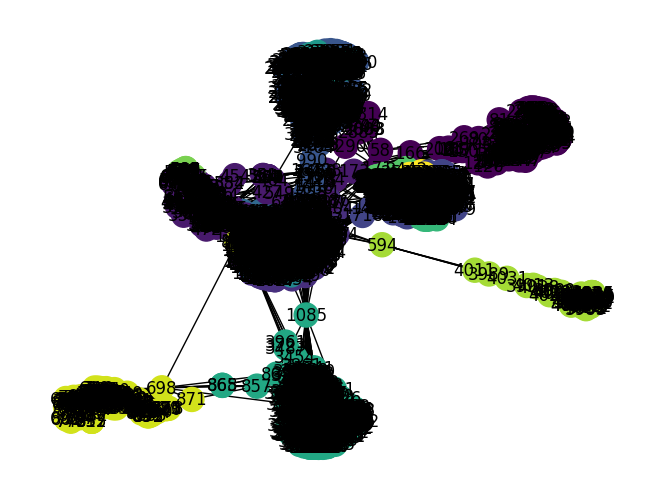

Execution time: 1.669830083847046 seconds
Accuracy: 0.5588235294117647
Precision: 0.27941176470588236
Recall: 0.5
F1 Score: 0.3584905660377359


In [58]:
import networkx as nx
import community as community_louvain
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import time
from collections import defaultdict

ground_truth_communities = [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}, 
                            {19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

def evaluate_solution(ground_truth, detected):
    ground_truth_labels = []
    detected_labels = []

    node_to_community_ground_truth = {}
    for idx, community in enumerate(ground_truth):
        for node in community:
            node_to_community_ground_truth[node] = idx

    node_to_community_detected = {}
    for node, community in detected.items():
        node_to_community_detected[node] = community

    for node in node_to_community_ground_truth:
        ground_truth_labels.append(node_to_community_ground_truth[node])
        detected_labels.append(node_to_community_detected.get(node, -1))

    accuracy = accuracy_score(ground_truth_labels, detected_labels)
    precision = precision_score(ground_truth_labels, detected_labels, average='macro', zero_division=0)
    recall = recall_score(ground_truth_labels, detected_labels, average='macro')
    f1 = f1_score(ground_truth_labels, detected_labels, average='macro')

    return accuracy, precision, recall, f1

start_time = time.time()

partition = community_louvain.best_partition(G)

modularity = community_louvain.modularity(partition, G)
end_time = time.time()
execution_time = end_time - start_time

print(f"Modularity of the partition: {modularity}")

pos = nx.spring_layout(G)
cmap = plt.get_cmap('viridis')
colors = [partition[node] for node in G.nodes()]

nx.draw(G, pos, node_color=colors, with_labels=True, cmap=cmap)
plt.savefig("image12")
plt.show()

detected_communities = defaultdict(list)
for node, community in partition.items():
    detected_communities[community].append(node)
detected_communities = list(detected_communities.values())

accuracy, precision, recall, f1 = evaluate_solution(ground_truth_communities, partition)
print(f'Execution time: {execution_time} seconds')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')